In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import folium
import numpy as np
import matplotlib as mpl
from folium.plugins import MarkerCluster
import json
import fiona 
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.ticker as ticker
import pandas as pd
from plotly import graph_objs as go
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import contextily as ctx

In [2]:
sns.set_theme()
sns.set_palette('colorblind')

In [3]:
strava_bike = pd.read_csv('StravaBike.csv')
strava_spatialBIKE=gpd.read_file("StravaBike.shp")
strava_bike = strava_bike.rename(columns={'edge_uid': 'edgeUID'})
strava_spatialB = strava_spatialBIKE.merge(strava_bike, on='edgeUID')

In [4]:
strava_data = pd.read_csv('StravaInitial.csv')
strava_spatial=gpd.read_file("SpatialStrava.shp")
strava_data = strava_data.rename(columns={'edge_uid': 'edgeUID'})
strava_spatialH = strava_spatial.merge(strava_data, on='edgeUID')

In [5]:
outline = gpd.read_file('NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shp')
MORAoutline= outline.loc[outline['UNIT_CODE']=='MORA']
MORAoutline=MORAoutline.to_crs(epsg=4326)
MORAhike=gpd.clip(strava_spatialH,MORAoutline)
MORAbike=gpd.clip(strava_spatialB,MORAoutline)

In [69]:
MORAbike['trip_count']=MORAbike['forward_trip_count']+MORAbike['reverse_trip_count']
MORAbike['people_count']=MORAbike['forward_people_count']+MORAbike['reverse_people_count']
MORAbike['male']=MORAbike['forward_male_people_count']+MORAbike['reverse_male_people_count']
MORAbike['female']=MORAbike['forward_female_people_count']+MORAbike['reverse_female_people_count']
MORAbike['13_19']=MORAbike['forward_13_19_people_count']+MORAbike['reverse_13_19_people_count']
MORAbike['20_34']=MORAbike['forward_20_34_people_count']+MORAbike['reverse_20_34_people_count']
MORAbike['35_54']=MORAbike['forward_35_54_people_count']+MORAbike['reverse_35_54_people_count']
MORAbike['55_64']=MORAbike['forward_55_64_people_count']+MORAbike['reverse_55_64_people_count']
MORAbike['65']=MORAbike['forward_65_plus_people_count']+MORAbike['reverse_65_plus_people_count']
MORAbike['age_sum']=(MORAbike['13_19']+MORAbike['20_34']+MORAbike['35_54']+MORAbike['55_64']+MORAbike['65'])
MORAbike['avg_age']=((MORAbike['13_19']*16)+(MORAbike['20_34']*27)+(MORAbike['35_54']*44)+(MORAbike['55_64']*59)+(MORAbike['65']*70))/MORAbike['age_sum']
MORAbike['gender_dif'] = MORAbike['female']-MORAbike['male']
MORAbike['percent_gender_dif'] = (MORAbike['female']-MORAbike['male'])/MORAbike['trip_count']
MORAbike['Time']=pd.to_datetime(MORAbike['hour'])
MORAbike['Hour'] = MORAbike['Time'].dt.hour

In [59]:
MORAbike.columns

Index(['edgeUID', 'osmId', 'geometry', 'activity_type', 'hour',
       'forward_trip_count', 'reverse_trip_count', 'forward_people_count',
       'reverse_people_count', 'forward_commute_trip_count',
       'reverse_commute_trip_count', 'forward_leisure_trip_count',
       'reverse_leisure_trip_count', 'forward_male_people_count',
       'reverse_male_people_count', 'forward_female_people_count',
       'reverse_female_people_count', 'forward_unspecified_people_count',
       'reverse_unspecified_people_count', 'forward_13_19_people_count',
       'reverse_13_19_people_count', 'forward_20_34_people_count',
       'reverse_20_34_people_count', 'forward_35_54_people_count',
       'reverse_35_54_people_count', 'forward_55_64_people_count',
       'reverse_55_64_people_count', 'forward_65_plus_people_count',
       'reverse_65_plus_people_count', 'forward_average_speed',
       'reverse_average_speed', 'trip_count', 'people_count', 'male', 'female',
       '13_19', '20_34', '35_54', '55_6

In [93]:
MORAhike['trip_count']=MORAhike['forward_trip_count']+MORAhike['reverse_trip_count']
MORAhike['male']=MORAhike['forward_male_people_count']+MORAhike['reverse_male_people_count']
MORAhike['female']=MORAhike['forward_female_people_count']+MORAhike['reverse_female_people_count']
MORAhike['13_19']=MORAhike['forward_13_19_people_count']+MORAhike['reverse_13_19_people_count']
MORAhike['20_34']=MORAhike['forward_20_34_people_count']+MORAhike['reverse_20_34_people_count']
MORAhike['35_54']=MORAhike['forward_35_54_people_count']+MORAhike['reverse_35_54_people_count']
MORAhike['55_64']=MORAhike['forward_55_64_people_count']+MORAhike['reverse_55_64_people_count']
MORAhike['65']=MORAhike['forward_65_plus_people_count']+MORAhike['reverse_65_plus_people_count']
MORAhike['age_sum']=(MORAhike['13_19']+MORAhike['20_34']+MORAhike['35_54']+MORAhike['55_64']+MORAhike['65'])
MORAhike['avg_age']=((MORAhike['13_19']*16)+(MORAhike['20_34']*27)+(MORAhike['35_54']*44)+(MORAhike['55_64']*59)+(MORAhike['65']*70))/MORAhike['age_sum']
MORAhike['gender_dif'] = MORAhike['female']-MORAhike['male']
MORAhike['percent_gender_dif'] = (MORAhike['female']-MORAhike['male'])/MORAhike['trip_count']

In [8]:
bikeHourly=MORAbike.groupby(['Hour']).count()
bikeHourly=bikeHourly.reset_index()
bikeHourly=bikeHourly[['Hour','trip_count']].sort_values(by='Hour')
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(bikeHourly.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'trip_count' : 0})
bikeHourly_df=pd.concat([bikeHourly, missing_df])
bikeHourly=bikeHourly_df.sort_values('Hour')
bikeHourly=bikeHourly.reset_index(drop=True)
bikeHourly

,Hour,trip_count
0,1,0
1,2,0
2,3,0
3,4,63
4,5,74
5,6,187
6,7,252
7,8,364
8,9,387
9,10,231


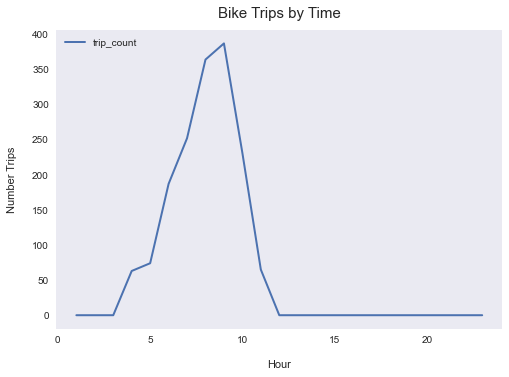

In [9]:
plt.style.use('seaborn')
plt.plot( 'Hour', 'trip_count', data=bikeHourly, linewidth=2)

plt.xlabel("Hour", labelpad=15)
plt.ylabel("Number Trips", labelpad=15)
plt.title("Bike Trips by Time", y=1.02, fontsize=15)
plt.grid(False)
plt.legend(loc = "upper left")
plt.show()

In [72]:
MORAbike['avg_age'].replace(0, np.nan, inplace=True)
MORAhike['avg_age'].replace(0, np.nan, inplace=True)

In [94]:
data = MORAhike['avg_age'].tolist()
binwidth = 8
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth),
         edgecolor="yellow", color="brown")
  
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

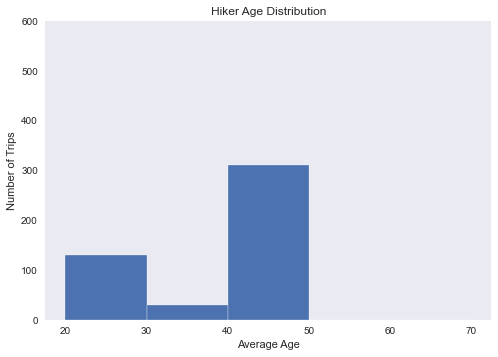

In [98]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
bins_list = [ 20,30,40, 50, 60, 70]
ax.hist(MORAhike['avg_age'],bins=bins_list)
  
# Set title
ax.set_title("Hiker Age Distribution")
  
# adding labels
ax.set_xlabel('Average Age')
ax.set_ylabel('Number of Trips')
#plt.hist(MORAhike['avg_age'], bins=[1, 2, 3, 4, 5])
plt.ylim([0,600])
#plt.xlim([15,70])
plt.grid(False)  
plt.show()

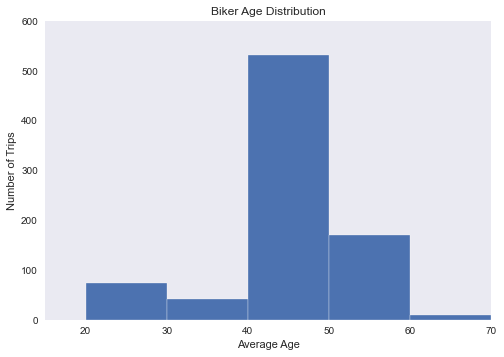

In [99]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
bins_list = [ 20,30,40, 50, 60, 70]
ax.hist(MORAbike['avg_age'],bins=bins_list)
  
# Set title
ax.set_title("Biker Age Distribution")
  
# adding labels
ax.set_xlabel('Average Age')
ax.set_ylabel('Number of Trips')
plt.ylim([0,600])
plt.xlim([15,70])
plt.grid(False)  
plt.show()

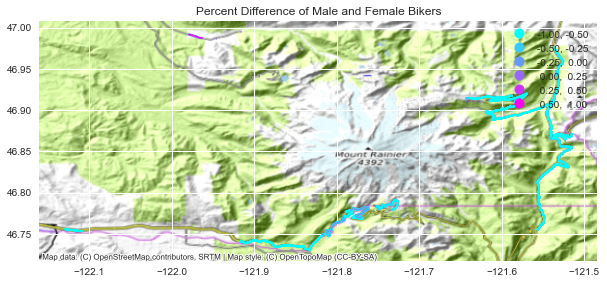

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
MORAbike.plot(column='percent_gender_dif', ax=ax,cmap='cool',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[-0.5,-0.25,0,0.25,0.5,1]))
plt.title("Percent Difference of Male and Female Bikers")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

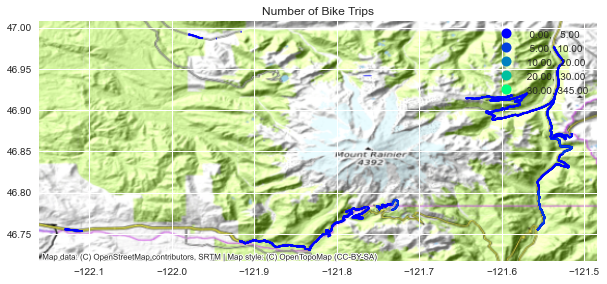

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
MORAbike.plot(column='forward_trip_count', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[5,10,20,30]))
plt.title("Number of Bike Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

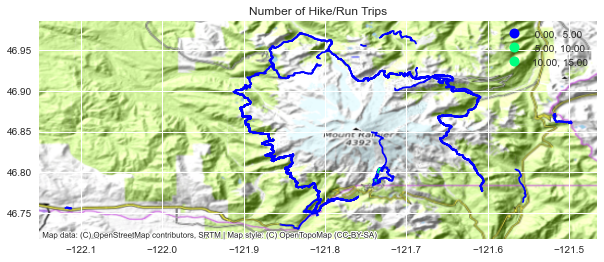

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
MORAhike.plot(column='forward_trip_count', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[5,10,15]))
plt.title("Number of Hike/Run Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

In [17]:
#total num of trips vs. total num edges 
bikeEdge = len(pd.unique(MORAbike['edgeUID']))
bikeTrip = MORAbike['trip_count'].sum()
hikeEdge = len(pd.unique(MORAhike['edgeUID']))
hikeTrip = MORAhike['trip_count'].sum()

In [18]:
print(bikeEdge)
print(bikeTrip)
print(hikeEdge)
print(hikeTrip)

173
35365
292
6730


In [19]:
MORAhikeTime=pd.DataFrame()

In [20]:
MORAhikeTime['edgeUID']=MORAhike['edgeUID']
MORAhikeTime['trip_count']=MORAhike['forward_trip_count']+MORAhike['reverse_trip_count']
MORAhikeTime['hr_0']=MORAhike['forward_hour_0_trip_count']+MORAhike['reverse_hour_0_trip_count']
MORAhikeTime['hr_1']=MORAhike['forward_hour_1_trip_count']+MORAhike['reverse_hour_1_trip_count']
MORAhikeTime['hr_2']=MORAhike['forward_hour_2_trip_count']+MORAhike['reverse_hour_2_trip_count']
MORAhikeTime['hr_3']=MORAhike['forward_hour_3_trip_count']+MORAhike['reverse_hour_3_trip_count']
MORAhikeTime['hr_4']=MORAhike['forward_hour_4_trip_count']+MORAhike['reverse_hour_4_trip_count']
MORAhikeTime['hr_5']=MORAhike['forward_hour_5_trip_count']+MORAhike['reverse_hour_5_trip_count']
MORAhikeTime['hr_6']=MORAhike['forward_hour_6_trip_count']+MORAhike['reverse_hour_6_trip_count']
MORAhikeTime['hr_7']=MORAhike['forward_hour_7_trip_count']+MORAhike['reverse_hour_7_trip_count']
MORAhikeTime['hr_8']=MORAhike['forward_hour_8_trip_count']+MORAhike['reverse_hour_8_trip_count']
MORAhikeTime['hr_9']=MORAhike['forward_hour_9_trip_count']+MORAhike['reverse_hour_9_trip_count']
MORAhikeTime['hr_10']=MORAhike['forward_hour_10_trip_count']+MORAhike['reverse_hour_10_trip_count']
MORAhikeTime['hr_11']=MORAhike['forward_hour_11_trip_count']+MORAhike['reverse_hour_11_trip_count']
MORAhikeTime['hr_12']=MORAhike['forward_hour_12_trip_count']+MORAhike['reverse_hour_12_trip_count']
MORAhikeTime['hr_13']=MORAhike['forward_hour_13_trip_count']+MORAhike['reverse_hour_13_trip_count']
MORAhikeTime['hr_14']=MORAhike['forward_hour_14_trip_count']+MORAhike['reverse_hour_14_trip_count']
MORAhikeTime['hr_15']=MORAhike['forward_hour_15_trip_count']+MORAhike['reverse_hour_15_trip_count']
MORAhikeTime['hr_16']=MORAhike['forward_hour_16_trip_count']+MORAhike['reverse_hour_16_trip_count']
MORAhikeTime['hr_17']=MORAhike['forward_hour_17_trip_count']+MORAhike['reverse_hour_17_trip_count']
MORAhikeTime['hr_18']=MORAhike['forward_hour_18_trip_count']+MORAhike['reverse_hour_18_trip_count']
MORAhikeTime['hr_19']=MORAhike['forward_hour_19_trip_count']+MORAhike['reverse_hour_19_trip_count']
MORAhikeTime['hr_20']=MORAhike['forward_hour_20_trip_count']+MORAhike['reverse_hour_20_trip_count']
MORAhikeTime['hr_21']=MORAhike['forward_hour_21_trip_count']+MORAhike['reverse_hour_21_trip_count']
MORAhikeTime['hr_22']=MORAhike['forward_hour_22_trip_count']+MORAhike['reverse_hour_22_trip_count']
MORAhikeTime['hr_23']=MORAhike['forward_hour_23_trip_count']+MORAhike['reverse_hour_23_trip_count']

In [21]:
MORAhikeTime.head()

,edgeUID,trip_count,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
180,234973496,5,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
341,234971228,5,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
342,234971228,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,234971228,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
505,234970983,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
MORAhikeTime['sumHours']=MORAhikeTime['hr_0']+ MORAhikeTime['hr_1']+MORAhikeTime['hr_2']+MORAhikeTime['hr_3']+MORAhikeTime['hr_4']
+MORAhikeTime['hr_5']+MORAhikeTime['hr_6']+MORAhikeTime['hr_7']+MORAhikeTime['hr_8']+ MORAhikeTime['hr_9']+MORAhikeTime['hr_10']
+MORAhikeTime['hr_11']+MORAhikeTime['hr_12']+MORAhikeTime['hr_13']+MORAhikeTime['hr_14']+MORAhikeTime['hr_15']+MORAhikeTime['hr_16']
+MORAhikeTime['hr_17']+MORAhikeTime['hr_18']+MORAhikeTime['hr_19']+MORAhikeTime['hr_20']+MORAhikeTime['hr_21']+MORAhikeTime['hr_22']
+MORAhikeTime['hr_23']

180       0
341       0
342       0
343       0
505       0
         ..
110756    0
110757    0
110758    0
110759    0
110760    0
Name: hr_23, Length: 1166, dtype: int64

In [23]:
bikeEdgeGrouped=MORAbike.groupby(['edgeUID']).count()
bikeEdgeGrouped=bikeEdgeGrouped.reset_index()
bikeEdgeGrouped=bikeEdgeGrouped[['edgeUID','trip_count']].sort_values(by='trip_count')
bikeEdgeGroupedSpatial=strava_spatialBIKE.merge(bikeEdgeGrouped, on='edgeUID')
bikeEdgeGroupedSpatial

,edgeUID,osmId,geometry,trip_count
0,234973420,439966672,"LINESTRING (-121.58783 46.91762, -121.58778 46...",10
1,234973409,435325445,"LINESTRING (-121.57947 46.89367, -121.57869 46...",11
2,234970676,12179933,"LINESTRING (-121.74242 46.78383, -121.74255 46...",16
3,234973517,179063675,"LINESTRING (-121.55247 46.90270, -121.55191 46...",10
4,234973400,439966672,"LINESTRING (-121.63779 46.91450, -121.63754 46...",11
...,...,...,...,...
168,234970696,12179933,"LINESTRING (-121.73973 46.78447, -121.73975 46...",17
169,234970996,179221519,"LINESTRING (-121.64180 46.91428, -121.64073 46...",5
170,234973789,287675694,"LINESTRING (-121.53649 46.97729, -121.53648 46...",15
171,234973516,287675708,"LINESTRING (-121.54190 46.88818, -121.54231 46...",15


In [24]:
bikeEdgeGroupedSpatial['trip_count'].max()

17

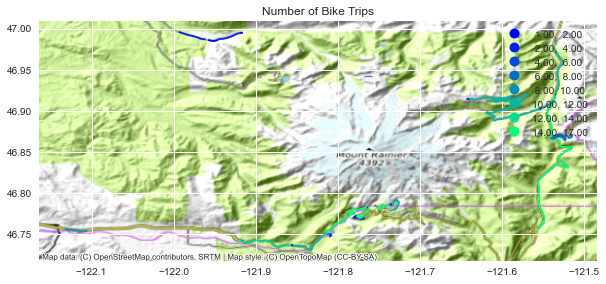

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
bikeEdgeGroupedSpatial.plot(column='trip_count', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[2,4,6,8,10,12,14]))
plt.title("Number of Bike Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

In [26]:
hikeEdgeGrouped=MORAhike.groupby(['edgeUID']).count()
hikeEdgeGrouped=hikeEdgeGrouped.reset_index()
hikeEdgeGrouped=hikeEdgeGrouped[['edgeUID','trip_count']].sort_values(by='trip_count')
hikeEdgeGroupedSpatial=strava_spatial.merge(hikeEdgeGrouped, on='edgeUID')
hikeEdgeGroupedSpatial

,edgeUID,osmId,geometry,trip_count
0,234973496,548934436,"LINESTRING (-121.50315 46.86161, -121.50329 46...",1
1,234971228,307873238,"LINESTRING (-121.79884 46.96160, -121.79906 46...",3
2,234970983,179370595,"LINESTRING (-121.64858 46.91526, -121.64791 46...",1
3,234970370,348839238,"LINESTRING (-121.86415 46.81366, -121.86393 46...",15
4,234970957,348456660,"LINESTRING (-121.66851 46.91758, -121.66900 46...",8
...,...,...,...,...
287,234970731,178755821,"LINESTRING (-121.73649 46.78649, -121.73630 46...",3
288,234970898,549221554,"LINESTRING (-121.65933 46.86536, -121.65931 46...",11
289,234970822,235233247,"LINESTRING (-121.72657 46.80881, -121.72656 46...",1
290,234970793,33819191,"LINESTRING (-121.73538 46.79814, -121.73566 46...",2


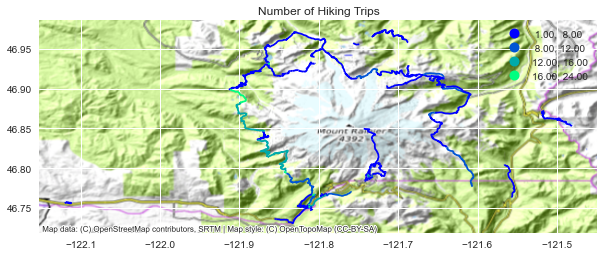

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
hikeEdgeGroupedSpatial.plot(column='trip_count', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[8,12,16]))
plt.title("Number of Hiking Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

In [28]:
hikeEdgeGroupedSpatial['person_miles']=hikeEdgeGroupedSpatial['trip_count']*(hikeEdgeGroupedSpatial['geometry'].length)

In [29]:
hikeEdgeGroupedSpatial['length']=(hikeEdgeGroupedSpatial['geometry'].length)

In [30]:
hikeEdgeGroupedSpatial.head()

,edgeUID,osmId,geometry,trip_count,person_miles,length
0,234973496,548934436,"LINESTRING (-121.50315 46.86161, -121.50329 46...",1,0.000172,0.000172
1,234971228,307873238,"LINESTRING (-121.79884 46.96160, -121.79906 46...",3,0.099825,0.033275
2,234970983,179370595,"LINESTRING (-121.64858 46.91526, -121.64791 46...",1,0.006157,0.006157
3,234970370,348839238,"LINESTRING (-121.86415 46.81366, -121.86393 46...",15,0.945040,0.063003
4,234970957,348456660,"LINESTRING (-121.66851 46.91758, -121.66900 46...",8,0.114476,0.014309


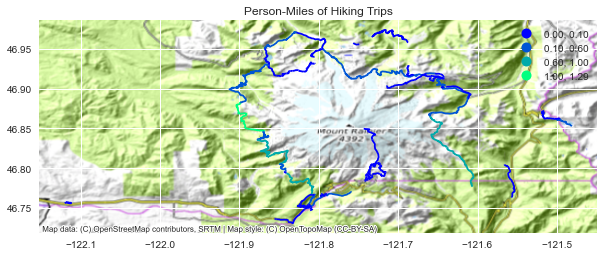

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
hikeEdgeGroupedSpatial.plot(column='person_miles', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[0.1,0.6,1]))
plt.title("Person-Miles of Hiking Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

In [32]:
bikeEdgeGroupedSpatial['person_miles']=bikeEdgeGroupedSpatial['trip_count']*(bikeEdgeGroupedSpatial['geometry'].length)

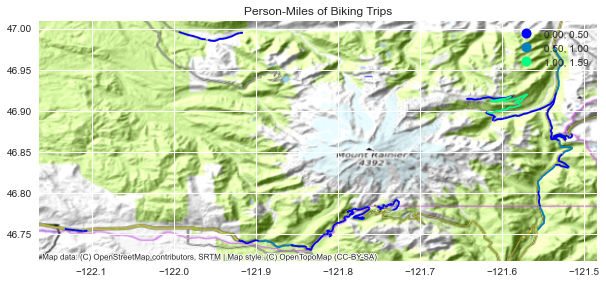

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
bikeEdgeGroupedSpatial.plot(column='person_miles', ax=ax,cmap='winter',scheme='User_Defined',legend='True',
                classification_kwds=dict(bins=[0.5,1]))
plt.title("Person-Miles of Biking Trips")
ctx.add_basemap(ax,crs=4326,source=ctx.providers.OpenTopoMap,zoom=10)

In [34]:
bikeEdgeGroupedSpatial['person_miles'].sum()

13.59447064056566

In [35]:
hikeEdgeGroupedSpatial['person_miles'].sum()

13.348954229635968